Here we will be analyzing the urban / rural data using balances on a phylogeny.  Specifically, we will be constructing our balances from a phylogeny, and run linear regression to test for specific microbial evolutionary divergences that could explain the differences between hunter/gatherer groups, rural and urban populations.

In [1]:
from gneiss.composition import ilr_transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc

from biom import load_table
from skbio import TreeNode
%matplotlib inline

We'll import the data and parse out the taxonomy.  The phylogeny tree is rather large, so we'll prune it down to make it a little more managable.

In [2]:
metadata = pd.read_table('mapping_meta_urban_rural.txt', index_col=0)
table = load_table('meta_urban_rural.biom')

ids = table.ids(axis='observation')
taxa = [table.metadata(id=i, axis='observation')['taxonomy'] for i in ids]
taxa = pd.DataFrame(taxa, index=ids, 
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'])

#tree = TreeNode.read('meta_ag4.27.17_qs850_qs10052_qs1448_100nt_placement.tog.tre')
tree = TreeNode.read('rural_phylogeny.nwk')

We'll filter out the low abundance species and clean up the metadata.

In [3]:
otu_filter = lambda val, id_, md: val.sum() > 10
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
table.filter(otu_filter, axis='observation')
table.filter(sparse_filter, axis='observation')

# drop out rows that are complete duplicates
metadata = metadata.drop_duplicates()

table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                     columns=table.ids(axis='observation'),
                     index=table.ids(axis='sample'))

Now we'll match the metadata and otu table axes. In addition, we'll make sure that the tree and the table are aligned appropriately.

In [4]:
from gneiss.util import match, match_tips, rename_internal_nodes
table, metadata = match(table, metadata)
table, tree = match_tips(table, tree)
# name the internal nodes that haven't been labeled
i = 0
for n in tree.levelorder():
    if n.name is None:
        n.name = "y%d" % i
        i+=1

Since we are using a phylogeny, there is a real danger that the balances that we are interested in are close to the tips of the tree.  Because of this, we will want to account for the noise due to low count variability.

So we will employ Dirichilet Multinomial bootstrapping, and bootstrap the balances.  This will give us an idea about the confidence intervals of our pvalues.

In [5]:
from gneiss.composition import ilr_transform
from gneiss.regression import ols
from scipy.stats import dirichlet
from statsmodels.sandbox.stats.multicomp import multipletests

seed = np.random.RandomState(0)
alpha = np.ones(table.shape)
T = 50
models = []
for i in range(T):
    draw = np.zeros(table.shape)
    draw = np.vstack([dirichlet.rvs(table.values[j, :] + alpha[j, :], random_state=seed) 
                      for j in range(table.shape[0])])
    draw = pd.DataFrame(draw, table.index, table.columns)
    res = ols(r"country + C(life_style_2, Treatment('urban'))", ilr_transform(draw, tree), metadata)
    res.fit()
    models.append(res)

After we have completed the bootstrapping, we will only investigate the median pvalue for variables in question.
Here, we will investigate the differences between the urban and remote farmers, and the differences between the urban and hunter/gather populations.

In [6]:
urban_pvals = pd.DataFrame({
    'rep%d'%i: r.pvalues.loc["C(life_style_2, Treatment('urban'))[T.remote_farmer]"] 
    for i, r in enumerate(models)})

med_urban_pvals = urban_pvals.apply(np.median, axis=1)
sig_urban_pvals = med_urban_pvals.loc[multipletests(med_urban_pvals, method='fdr_bh')[0]]

hunter_pvals = pd.DataFrame({
    'rep%d'%i: r.pvalues.loc["C(life_style_2, Treatment('urban'))[T.hunter-gatherer]"]    
    for i, r in enumerate(models)})

med_hunter_pvals = hunter_pvals.apply(np.median, axis=1)
sig_hunter_pvals = med_urban_pvals.loc[multipletests(med_hunter_pvals, method='fdr_bh')[0]]

Let's try to investigate some of the interesting balances.

In [7]:
sig_urban_pvals.sort_values().head(20)

y2281    6.675979e-39
y1799    1.774245e-33
y463     1.467310e-32
y1699    1.427039e-20
y2230    7.149831e-15
y1555    1.470060e-13
y196     7.341755e-13
y2105    1.351000e-11
y855     6.248841e-11
y2173    9.408221e-10
y2161    1.360334e-09
y1328    2.394268e-09
y118     2.994078e-09
y488     3.695213e-09
y979     9.853145e-09
y1479    1.683942e-08
y46      2.168458e-08
y726     2.172699e-08
y1336    9.588275e-08
y2371    1.155596e-07
dtype: float64

In [8]:
sig_hunter_pvals.sort_values().head(20)

y2281                                      6.675979e-39
y1799                                      1.774245e-33
y463                                       1.467310e-32
y1699                                      1.427039e-20
y196                                       7.341755e-13
y855                                       6.248841e-11
y118                                       2.994078e-09
y1479                                      1.683942e-08
y46                                        2.168458e-08
y1099                                      9.608367e-05
HOcQnKrPN003897g  Phascolarctobacterium    3.134678e-03
y166                                       1.953626e-02
y1959                                      3.052993e-02
y268                                       6.943671e-02
y41                                        1.320395e-01
y793                                       4.744925e-01
dtype: float64

A couple of balances that appear to interesting as noted as y46 and y463.  Let's investigate those balances in more detail.

In [9]:
from gneiss.util import NUMERATOR, DENOMINATOR
balances = ilr_transform(table+1, tree)
balance_summary = pd.concat((taxa.loc[tree.find('y46').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y46').children[DENOMINATOR].subset()],
                             taxa.loc[tree.find('y463').children[NUMERATOR].subset()],
                             taxa.loc[tree.find('y463').children[DENOMINATOR].subset()]))

Since we want to try to visualize both of these balances together, we'll need to perform some manipulations on the dataframes. Below, we will define some convenience functions to do this.

In [10]:
def balance_name(x):
    if x in tree.find('y46').subset():
        return 'y46'
    else:
        return 'y436'

def position(x):
    if (x in tree.find('y46').children[NUMERATOR].subset() or
        x in tree.find('y463').children[NUMERATOR].subset()
       ):
        return 'numerator'
    else:
        return 'denominator'

balance_summary['balance'] = list(map(balance_name, balance_summary.index))
balance_summary['position'] = list(map(position, balance_summary.index))

Here we will plot the proportions of the clade identified within each of these balances.

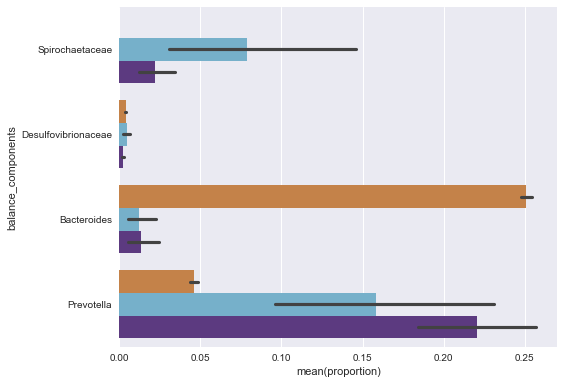

In [11]:
import seaborn as sns
ctable = table.apply(lambda x: x / x.sum(), axis=1)
log_counts = pd.DataFrame({
'Spirochaetaceae': ctable[list(tree.find('y46').children[NUMERATOR].subset())].sum(axis=1),
'Desulfovibrionaceae': ctable[list(tree.find('y46').children[DENOMINATOR].subset())].sum(axis=1),
'Bacteroides': ctable[list(tree.find('y463').children[NUMERATOR].subset())].sum(axis=1),
'Prevotella': ctable[list(tree.find('y463').children[DENOMINATOR].subset())].sum(axis=1)
})

data = pd.merge(log_counts, metadata, left_index=True, right_index=True)
varz = list(log_counts.columns) + ['life_style_2']

df = pd.melt(data[varz], id_vars=['life_style_2'], var_name='balance_components', value_name='proportion')
#sns.factorplot(hue='life_style_2', y='balance', x='magnitude', data=df, kind='violin', size=4, aspect=2)
ax = sns.barplot(hue='life_style_2', y='balance_components', x='proportion', data=df, 
                   hue_order=['urban', 'hunter-gatherer', 'remote_farmer'],
                   order=['Spirochaetaceae', 'Desulfovibrionaceae', 'Bacteroides', 'Prevotella'],
                   palette={'urban':'#d98134',
                            'remote_farmer':'#5b2e8c',
                            'hunter-gatherer':'#68b6d8'})
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('rural_vs_urban_proportion_barplots.pdf')

Finally, we'll plot the boxplots of the balances of these clades, to show how they differ between the urban, rural and hunter/gatherer groups.

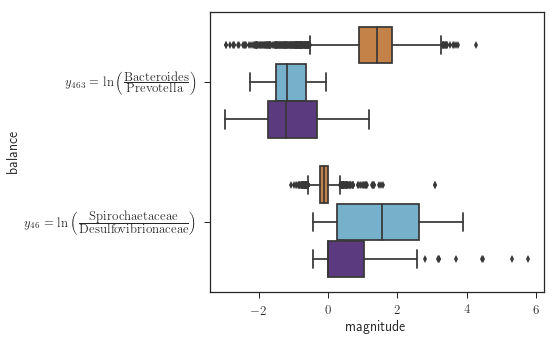

In [12]:
import seaborn as sns
rc('text', usetex=True)

sns.set(font_scale=1.3) 

sns.set_style('white')
sns.set_style('ticks')
plt.figure(figsize=(8, 5))
varz = ['y463', 'y46', 'life_style_2']
data = pd.merge(balances, metadata, left_index=True, right_index=True)

df = pd.melt(data[varz], id_vars=['life_style_2'], var_name='balance', value_name='magnitude')
ax = sns.boxplot(hue='life_style_2', y='balance', x='magnitude', data=df, 
                 hue_order=['urban', 'hunter-gatherer', 'remote_farmer'],
                 palette={'urban':'#d98134',
                          'remote_farmer':'#5b2e8c',
                          'hunter-gatherer':'#68b6d8'})
ax.set_yticklabels([r'$y_{463}=\ln \bigg(  \frac{\textrm{Bacteroides}}{\textrm{Prevotella }} \bigg)$',
                    r'$y_{46}=\ln \bigg( \frac{\textrm{Spirochaetaceae}}{\textrm{Desulfovibrionaceae}} \bigg)$'])
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('rural_vs_urban_boxplots.pdf')

From here, we can see that there are a few interesting clades that can explain the differences between the urban, rural and hunter and gather groups.